In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Window
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


#### data

In [0]:
path = '/mnt/datalake/tmp/amani/data_token/data_info_token2'
data = spark.read.parquet(path)

#### Les fonctions

In [0]:
def add_columns(data):
  
  data_processing=(data.withColumn("Age_token_jour",col("Age_token")/24)
                       .withColumn("Age_token_mois",col("Age_token_jour")/30)
                       .withColumn("temps_inactivite_mois",col("temps_inactivite")/30)
                       #0 actif , 1 inactif 
                      .withColumn("profil_utilisateur",when(col("temps_inactivite_mois")<5,0).otherwise(1))
                   
                      #ajouter la colonne de confinement 
                      .withColumn("confinement",
                                   when(((data.date_premiere_cap>="2020-03-17" )& (data.date_premiere_cap<="2020-05-10" ))
                                  |((data.date_premiere_cap>="2020-10-30" )& (data.date_premiere_cap<="2020-12-15" ))
                                  |((data.date_premiere_cap>="2021-04-03" )& (data.date_premiere_cap<="2021-05-03" )),True)
                                  .otherwise(False)))
                      #enlever l'année 2018
  data_processing=data_processing.filter(~year("date_premiere_cap").isin([2018]))
  return data_processing

In [0]:
def add_device_tendance(df):
  df['date_premiere_cap'] = pd.to_datetime(df['date_premiere_cap'])
  df["device_tend"] = df["nombre_device"].diff()
  df['device_tendance'] = np.where(df["device_tend"]<0, 0, 1)
  return df


In [0]:
def group_data(df,resample):
  df=df.set_index("date_premiere_cap")
  daily_data=df.resample(resample).agg({'nombre_trajet':'sum',
                                          'nombre_device':'sum',
                                          'nombre_km':'sum',
                                          'temps_inactivite_max_entre_2trajets':'sum',
                                          'Age_token_mois':'sum',
                                          'temps_inactivite_mois':'sum',
                                          'token':'count',
                                          'profil_utilisateur':'sum',
                                           'confinement':'sum',
                                            'device_tendance':'sum'})
  return daily_data

In [0]:

def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=365)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    #return trend, seasonal, residual


In [0]:
def analyse_stationnarite(df):
  plt.figure(figsize=(10,5))
  rolling_mean = df.rolling(window = 12).mean()
  rolling_std =df.rolling(window = 12).std()
  plt.plot(df, color = 'blue', label = 'Origine')
  plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
  plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
  plt.legend(loc = 'best')
  plt.title('Moyenne et Ecart-type mobiles')
  plt.show()

In [0]:
def obtain_adf_kpss_results(timeseries, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series
    
    Args:
        time_series (df): Dataframe of univariate time series  
        max_d (int): Max value of how many times apply difference
        
    Return:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times 
        differencing on a time-series.
    
    """
    
    results=[]

    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <=0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True
            
        stationary = adf_stationary & kpss_stationary
            
        results.append((idx,adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))
    
    # Construct DataFrame 
    results_df = pd.DataFrame(results, columns=['d','adf_stats','p-value', 'is_adf_stationary','is_kpss_stationary','is_stationary' ])
    
    return results_df

In [0]:
def train_test_split(data):
    size=int(len(data)*0.7)
    train =data.iloc[0:size] 
    test = data.iloc[size:] 
    return train, test

#### Daily_data

In [0]:
data_processing=add_columns(data)

In [0]:
data_processing.select("token","profil_utilisateur").display()

token,profil_utilisateur
77395357,1
s9obju10,1
98885414,1
45412986,1
ANONYMOUSTOKEN4247,1
ANONYMOUSTOKEN2178,1
egha6n10,1
04065471,0
pjkop410,1
64199360,1


In [0]:
data_processing=add_columns(data)
#to pandas 
df= data_processing.toPandas()
df_tendance=add_device_tendance(df)
daily_data=group_data(df_tendance,resample="D")

In [0]:
train,test=train_test_split(daily_data)

#### decomposotion de la serie temporelle (trend,seasonality,residual)

<command-4069576222524073>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
 decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=365)

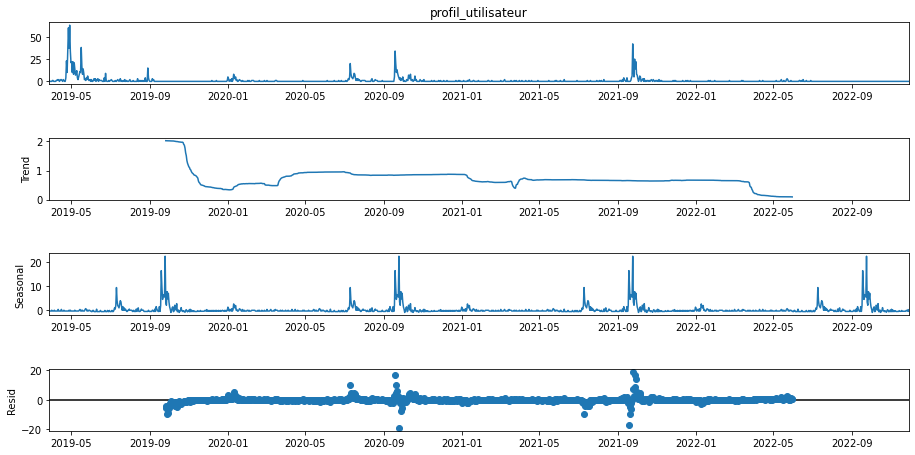

In [0]:
seasonal_decompose(daily_data.profil_utilisateur)

In [0]:
#Il y a une tendance à la hausse sur les ventes. Par conséquent, cette série temporelle n'est pas stationnaire.
#À partir de la composante saisonnière, nous pouvons observer que le modèle est additif, *
#puisque la composante saisonnière est similaire (ne se multiplie pas) sur la période de temps.


<command-4069576222524073>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
 decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=365)

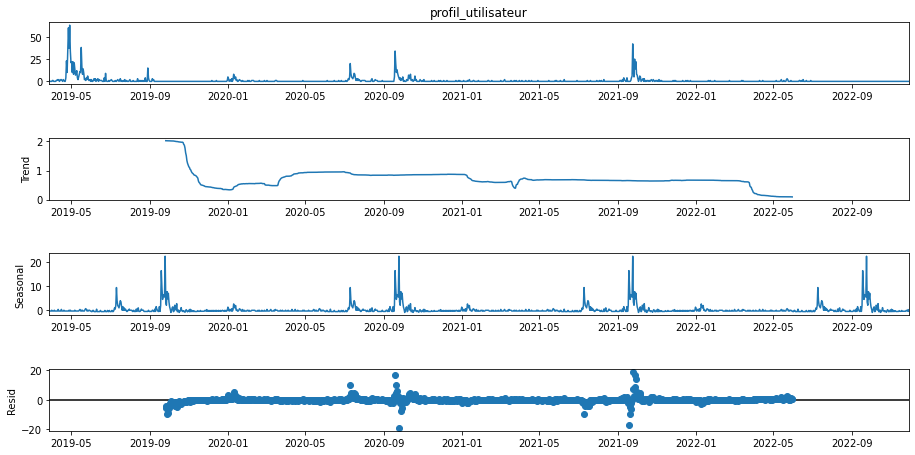

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-1158552579743678> in <module> 
 1 decompose = seasonal_decompose ( daily_data [ "profil_utilisateur" ] ) 
 ----> 2 decompose . plot ( ) ; 
 3 #plt.rcParams['figure.figsize'] = (12, 8); 

 AttributeError : 'NoneType' object has no attribute 'plot'

In [0]:
decompose = seasonal_decompose(daily_data["profil_utilisateur"])
decompose.plot();
#plt.rcParams['figure.figsize'] = (12, 8);

#### Analyse_stationnarite

##### Moyenne mobile et ecart_type

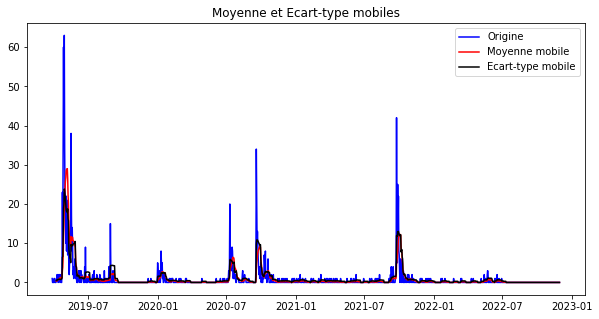

In [0]:
analyse_stationnarite(daily_data["profil_utilisateur"])
#la moyenne mibile et ecart type mobile ne sont pas constantes aucours de temps donc notre serie n'est pas stationnaire 

##### Appliquer des tests de stationnarité

In [0]:
obtain_adf_kpss_results(daily_data["profil_utilisateur"],3)
#d=1, il suffit d'appliquer la différenciation une seule fois pour que notre série temporelle soit stationnaire.

/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

 warnings.warn(
/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

 warnings.warn(
Out[45]:

,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,9.658452e-07,0.022387,True,False,False
1,1,3.271616e-18,0.100000,True,True,True
2,2,2.239402e-29,0.100000,True,True,True


#### ACF et PACF

In [0]:
# Les tracés d'autocorrélation et d'autocorrélation partielle peuvent donner des indices sur les valeurs prometteuses des paramètres ARIMA.
# Cela peut également nous montrer si nous devons appliquer une différenciation ou si nous l'avons trop appliquée.

# Fonction d'autocorrélation ACF décrit à quel point la valeur actuelle de la série est liée à ses valeurs passées.
# Les barres du tracé ACF représentent les valeurs ACF à des décalages croissants.
# La zone ombrée en bleu représente l'intervalle de confiance, qui est défini sur 95 % par défaut. 
# Si les barres se trouvent à l'intérieur de la région ombrée en bleu, elles ne sont pas statistiquement significatives.
#Partial AutoCorrelation Function - PACF décrit uniquement la relation directe entre une observation et son décalage.
#Fondamentalement, au lieu de trouver des corrélations de présent avec des décalages comme ACF, 
#il trouve une corrélation des résidus (qui reste après avoir supprimé les effets qui sont déjà expliqués par le ou les décalages précédents).



In [0]:
#Comme indiqué précédemment, ACF et PACF peuvent également donner des conseils sur la différenciation.
#Il est important de rendre la série chronologique stationnaire avant de créer ces tracés. 
#Si les valeurs ACF sont élevées et s'éloignent très lentement, c'est un signe que les données ne sont pas stationnaires, elles doivent donc être différenciées.

##### Avant diff()

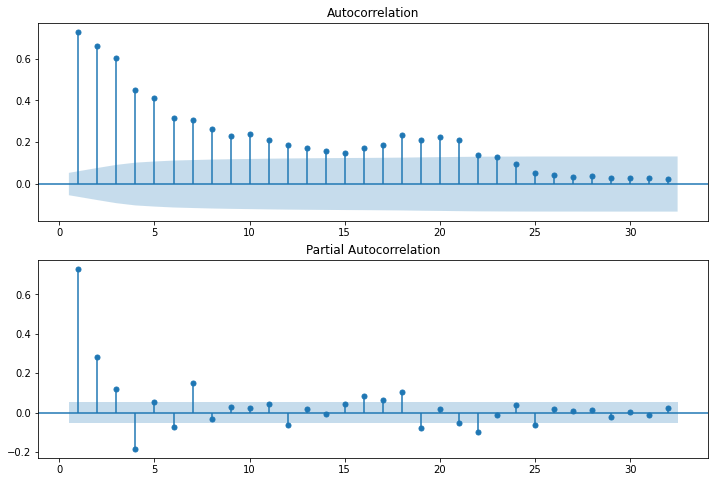

In [0]:


# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF  ax1
plot_acf(daily_data["profil_utilisateur"], ax=ax1)

# Plot the PACF  ax2
plot_pacf(daily_data["profil_utilisateur"], ax=ax2)

plt.show()

##### Apres diff()

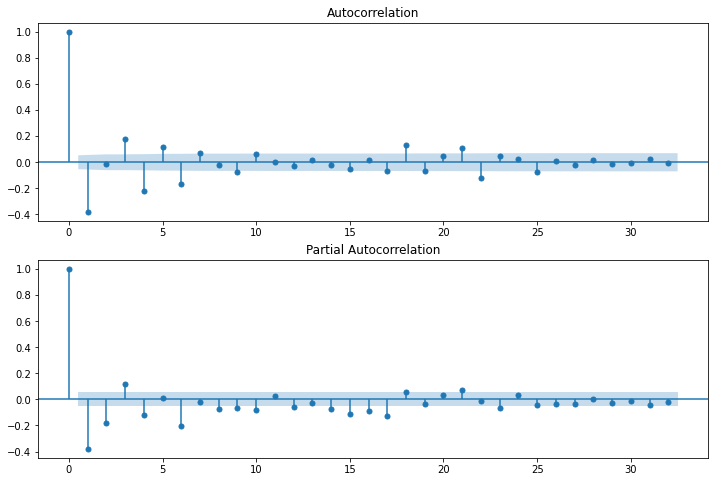

In [0]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF  ax1
plot_acf(daily_data["profil_utilisateur"].diff().dropna(),ax=ax1)

# Plot the PACF  ax2
plot_pacf(daily_data["profil_utilisateur"].diff().dropna(), ax=ax2)

plt.show()

test1 arima

In [0]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-6
for p in range(7):
  # Loop over q values from 0-6
    for q in range(7):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(daily_data["profil_utilisateur"], order=(p,1,q), freq="D") #because adf test showed that d=1
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])

/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
 warn('Non-stationary starting autoregressive parameters'
/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
 warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 warnings.warn("Maximum Likelihood optimization failed to "
/databricks/python/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 warnings.warn("Maximum Likelihood optimization failed to "
/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
 warn('Non-stationary starting autoregressive parameters'
/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
 warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 warnings.warn("Maximum Likelihood optimization failed to "
/databricks/python/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 warnings.warn("Maximum Likelihood optimization failed to "
/databricks/python/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 warnings.warn("Maximum Likelihood optimization failed to "
/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
 warn('Non-stationary starting autoregressive parameters'
/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
 warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 warnings.warn("Maximum Likelihood optimization failed to "
/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
 warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 warnings.warn("Maximum Likelihood optimization failed to "
/databricks/python/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 warnings.warn("Maximum Likelihood optimization failed to "
/databricks/python/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 warnings.warn("Maximum Likelihood optimization failed to "
/databricks/python/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 warnings.warn("Maximum Likelihood optimization failed to "
/databrick

In [0]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC').head(5)


Out[19]:

,p,q,AIC,BIC
26,3,5,6415.608230,6462.425477
33,4,5,6418.116133,6470.135296
27,3,6,6421.230216,6473.249379
34,4,6,6421.481582,6478.702662
46,6,4,6422.260433,6479.481513


In [0]:
arima_model = SARIMAX(daily_data["profil_utilisateur"], order=(3,1,5))
# fit model
arima_results = arima_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

/databricks/python/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 warnings.warn("Maximum Likelihood optimization failed to "
MAE: 0.921

In [0]:
daily_data["profil_utilisateur"].describe()

Out[37]: count 1343.000000
mean 0.972450
std 4.152458
min 0.000000
25% 0.000000
50% 0.000000
75% 0.000000
max 63.000000
Name: profil_utilisateur, dtype: float64

In [0]:
#L'erreur moyenne moyenne est d'environ 1 personne  par jour c'est le mm nombre de personne inactive  moyen  par jour 

In [0]:
arima_results.summary()

Out[23]:

SARIMAX Results 
 
 Dep. Variable: profil_utilisateur No. Observations: 1343 
 
 
 Model: SARIMAX(3, 1, 5) Log Likelihood -3198.804 
 
 
 Date: Tue, 06 Dec 2022 AIC 6415.608 
 
 
 Time: 21:31:43 BIC 6462.425 
 
 
 Sample: 03-28-2019 HQIC 6433.146 
 
 
 - 11-29-2022 
 
 
 Covariance Type: opg 
 
 
 
 
 coef std err z P>|z| [0.025 0.975] 
 
 
 ar.L1 -0.9119 0.024 -38.712 0.000 -0.958 -0.866 
 
 
 ar.L2 0.5963 0.019 31.027 0.000 0.559 0.634 
 
 
 ar.L3 0.5711 0.024 24.042 0.000 0.525 0.618 
 
 
 ma.L1 0.4651 0.028 16.341 0.000 0.409 0.521 
 
 
 ma.L2 -1.0571 0.026 -40.722 0.000 -1.108 -1.006 
 
 
 ma.L3 -0.2071 0.030 -6.857 0.000 -0.266 -0.148 
 
 
 ma.L4 0.1134 0.021 5.454 0.000 0.073 0.154 
 
 
 ma.L5 -0.2745 0.016 -16.648 0.000 -0.307 -0.242 
 
 
 sigma2 6.9039 0.069 100.451 0.000 6.769 7.039 
 
 
 
 
 Ljung-Box (L1) (Q): 0.00 Jarque-Bera (JB): 384280.48 
 
 
 Prob(Q): 0.95 Prob(JB): 0.00 
 
 
 Heteroskedasticity (H): 0.44 Skew: 6.70 
 
 
 Prob(H) (two-sided): 0.00 Kurtosis: 84.81 
 
 Warnings: [1] Covariance matrix calculated using the outer product of gradients (complex-step).

/databricks/python/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
 ax.plot(x, y, fmt, **plot_style)

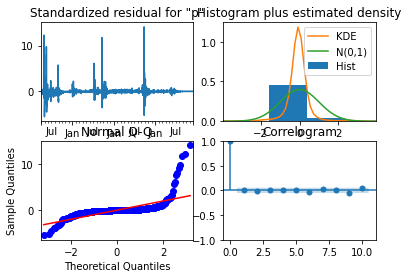

In [0]:
# Create the 4 diagostics plots using plot_diagnostics method
arima_results.plot_diagnostics()
plt.show()


In [0]:
#l'histogramme montre la distribution mesurée des résidus 
#la ligne orange montre la courbe de KDE (version lissée de l'histogramme)
#La ligne verte montre une distribution normale
#Pour un bon modèle, la ligne orange doit être similaire à la ligne verte

#### SARIMA

In [0]:
#En règle générale, d + D ne doit pas être supérieur à 2 donc D=1

In [0]:
# Take the first and seasonal differences (S=7) and drop NaNs
daily_data_profil_utilisateur_diff = daily_data["profil_utilisateur"].diff().diff(10).dropna()


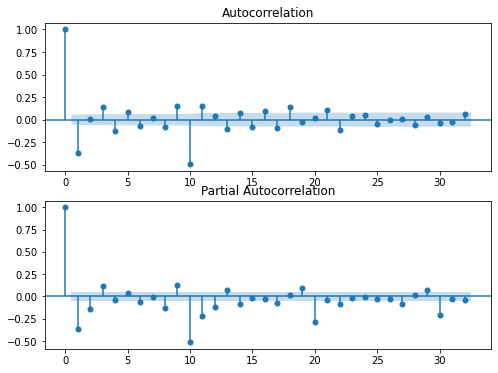

In [0]:
# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(daily_data_profil_utilisateur_diff, ax=ax1)

# Plot the PACF on ax2
plot_pacf(daily_data_profil_utilisateur_diff, ax=ax2)

plt.show()


In [0]:

import pmdarima as pm

# Create auto_arima model
model1 = pm.auto_arima(train["profil_utilisateur"], #time series
                      seasonal=True, # is the time series seasonal
                      m=1, # the seasonal period - ?
                      d=1, # non-seasonal difference order
                      #D=1, # seasonal difference order
                 	  max_p=6, # max value of p to test 
                      max_q=6, # max value of p to test
                      #max_P=6, # max value of P to test 
                      #max_Q=6, # max value of Q to test 
                      information_criterion='aic', # used to select best mode
                      trace=True, # prints the information_criterion for each model it fits
                      error_action='ignore', # ignore orders that don't work
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True) 

# Print model summary
print(model1.summary())





Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept : AIC=4890.245, Time=5.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept : AIC=5101.777, Time=3.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept : AIC=4959.020, Time=3.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept : AIC=4939.909, Time=3.13 sec
 ARIMA(0,1,0)(0,0,0)[0] : AIC=5099.777, Time=3.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept : AIC=4920.597, Time=3.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept : AIC=4888.255, Time=3.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept : AIC=4940.190, Time=3.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept : AIC=4929.247, Time=3.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept : AIC=4890.246, Time=3.59 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept : AIC=4916.876, Time=3.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept : AIC=inf, Time=4.50 sec
 ARIMA(2,1,1)(0,0,0)[0] : AIC=4886.255, Time=3.23 sec
 ARIMA(1,1,1)(0,0,0)[0] : AIC=4938.190, Time=3.18 sec
 ARIMA(2,1,0)(0,0,0)[0] : AIC=4927.247, Time=3.12 sec
 ARIMA(3,1,1)(0,0,0)[0] : AIC=4888.246, Time=3.32 sec
 ARIMA(2,1,2)(0,0,0)[0] : AIC=4888.245, Time=3.24 sec
 ARIMA(1,1,0)(0,0,0)[0] : AIC=4957.020, Time=3.01 sec
 ARIMA(1,1,2)(0,0,0)[0] : AIC=4918.597, Time=3.14 sec
 ARIMA(3,1,0)(0,0,0)[0] : AIC=4914.876, Time=3.18 sec
 ARIMA(3,1,2)(0,0,0)[0] : AIC=inf, Time=3.91 sec

Best model: ARIMA(2,1,1)(0,0,0)[0] 
Total fit time: 71.614 seconds
 SARIMAX Results 
==============================================================================
Dep. Variable: y No. Observations: 940
Model: SARIMAX(2, 1, 1) Log Likelihood -2439.127
Date: Sun, 01 Jan 2023 AIC 4886.255
Time: 12:31:13 BIC 4905.634
Sample: 0 HQIC 4893.643
 - 940 
Covariance Type: opg 
==============================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------
ar.L1 -1.1638 0.023 -50.278 0.000 -1.209 -1.118
ar.L2 -0.4547 0.012 -37.637 0.000 -0.478 -0.431
ma.L1 0.7759 0.027 28.816 0.000 0.723 0.829
sigma2 10.5577 0.109 97.241 0.000 10.345 10.770
===================================================================================
Ljung-Box (L1) (Q): 0.00 Jarque-Bera (JB): 95415.84
Prob(Q): 0.98 Prob(JB): 0.00
Heteroskedasticity (H): 0.42 Skew: 3.94
Prob(H) (two-sided): 0.00 Kurtosis: 51.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

In [0]:

sarima_02_model = ARIMA(train["profil_utilisateur"], order=(2,0,1))
sarima_02_results = sarima_02_model.fit()


# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_02_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

/databricks/python/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
 FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
 FutureWarning)

 warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
MAE: 1.119

In [0]:
# # Prédiction de la série temporelle sur un horizon de 50 points
# prediction = sarima_02_results.predict(start=test["profil_utilisateur"].index[0], end=test["profil_utilisateur"].index[-1])

# # Tracé de la prédiction et de l'intervalle de confiance (par défaut, l'intervalle de confiance est à 95%)
# _, conf_int = sarima_02_results.plot_predict(start=test["profil_utilisateur"].index[0], end=test["profil_utilisateur"].index[-1])

# # Affichage du graphique
# plt.show()

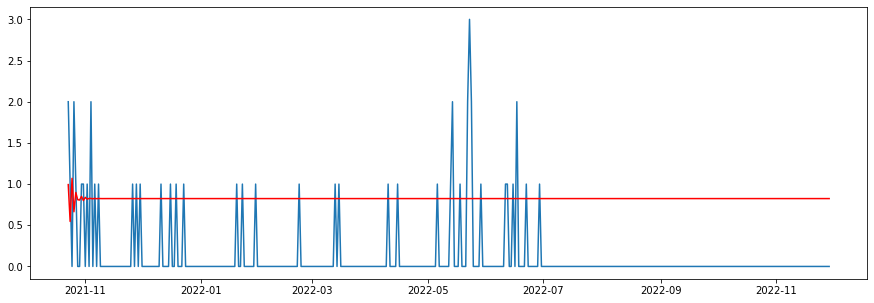

In [0]:
# Prédiction des labels sur les données de test
y_pred = sarima_02_results .predict(start=test["profil_utilisateur"].index[0], end=test["profil_utilisateur"].index[-1])

# Tracé des résultats de prédiction sur les données de test
plt.figure(figsize=(15,5))
plt.plot(test["profil_utilisateur"])
plt.plot(y_pred, color="red")
plt.show()





/databricks/python/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
 ax.plot(x, y, fmt, **plot_style)

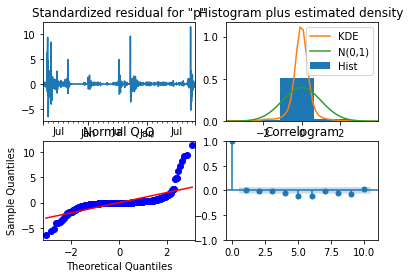

In [0]:
# Create the 4 diagostics plots
sarima_02_results.plot_diagnostics()
plt.show()

####modele3

In [0]:
daily_data["profil_utilisateur"].head()

Out[24]: date_premiere_cap
2019-03-28 1
2019-03-29 0
2019-03-30 0
2019-03-31 0
2019-04-01 0
Freq: D, Name: profil_utilisateur, dtype: int32

In [0]:
train,test=train_test_split(daily_data["profil_utilisateur"])

In [0]:
import pmdarima as pm
 
model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=0,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] : AIC=5728.438, Time=2.83 sec
 ARIMA(1,0,0)(0,0,0)[0] : AIC=4977.550, Time=2.87 sec
 ARIMA(0,0,1)(0,0,0)[0] : AIC=5297.707, Time=2.84 sec
 ARIMA(2,0,0)(0,0,0)[0] : AIC=4899.306, Time=2.87 sec
 ARIMA(3,0,0)(0,0,0)[0] : AIC=4886.730, Time=2.98 sec
 ARIMA(4,0,0)(0,0,0)[0] : AIC=4857.292, Time=3.01 sec
 ARIMA(5,0,0)(0,0,0)[0] : AIC=4855.863, Time=2.91 sec
 ARIMA(5,0,1)(0,0,0)[0] : AIC=4839.559, Time=3.27 sec
 ARIMA(4,0,1)(0,0,0)[0] : AIC=4838.746, Time=3.74 sec
 ARIMA(3,0,1)(0,0,0)[0] : AIC=4840.324, Time=2.96 sec
 ARIMA(4,0,2)(0,0,0)[0] : AIC=4839.395, Time=3.14 sec
 ARIMA(3,0,2)(0,0,0)[0] : AIC=4839.339, Time=3.05 sec
 ARIMA(5,0,2)(0,0,0)[0] : AIC=4840.993, Time=3.39 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept : AIC=4835.164, Time=3.28 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept : AIC=4837.426, Time=3.07 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept : AIC=4852.602, Time=3.05 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept : AIC=4835.547, Time=3.57 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept : AIC=4835.209, Time=3.48 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept : AIC=4884.108, Time=2.99 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept : AIC=4835.976, Time=3.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept : AIC=4851.887, Time=2.98 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept : AIC=4836.692, Time=3.75 sec

Best model: ARIMA(4,0,1)(0,0,0)[0] intercept
Total fit time: 72.603 seconds
 SARIMAX Results 
==============================================================================
Dep. Variable: y No. Observations: 940
Model: SARIMAX(4, 0, 1) Log Likelihood -2410.582
Date: Wed, 07 Dec 2022 AIC 4835.164
Time: 17:11:07 BIC 4869.085
Sample: 0 HQIC 4848.095
 - 940 
Covariance Type: opg 
==============================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------
intercept 0.4387 0.373 1.177 0.239 -0.292 1.169
ar.L1 -0.1921 0.038 -4.993 0.000 -0.267 -0.117
ar.L2 0.5929 0.022 27.229 0.000 0.550 0.636
ar.L3 0.3489 0.014 25.719 0.000 0.322 0.375
ar.L4 -0.0791 0.020 -4.014 0.000 -0.118 -0.040
ma.L1 0.7407 0.039 19.075 0.000 0.665 0.817
sigma2 9.8722 0.145 68.236 0.000 9.589 10.156
===================================================================================
Ljung-Box (L1) (Q): 0.00 Jarque-Bera (JB): 162666.85
Prob(Q): 0.95 Prob(JB): 0.00
Heteroskedasticity (H): 0.42 Skew: 6.36
Prob(H) (two-sided): 0.00 Kurtosis: 66.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

In [0]:
results = model.fit(train)

# Make predictions
predictions = results.predict(start=len(train),end=len(test))

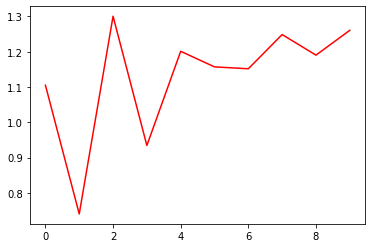

In [0]:
predictions = results.predict(start=len(train),end=len(test))
plt.plot(predictions, color='red')
plt.show()

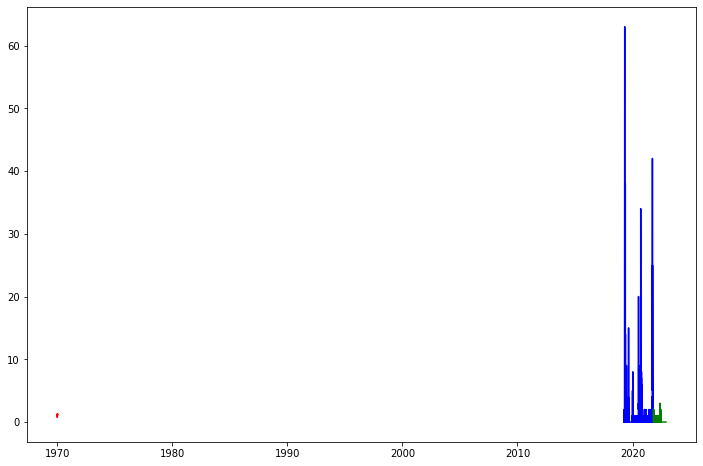

In [0]:
plt.figure(figsize=(12, 8))
plt.plot(train, color='blue')
plt.plot(test, color='green')
#preds = results_ARIMA_train.fittedvalues
plt.plot(predictions, color='red')
plt.show()


In [0]:
train=pd.DataFrame(train)
test=pd.DataFrame(test)

In [0]:
#predict train
forecast_train = model.predict(len(train),train)
train["Forecast_ARIMAX"]= forecast_train

In [0]:

#predict test
forecast_test = model.predict(len(test),test)
test["Forecast_ARIMAX"] = forecast_test

Out[62]:

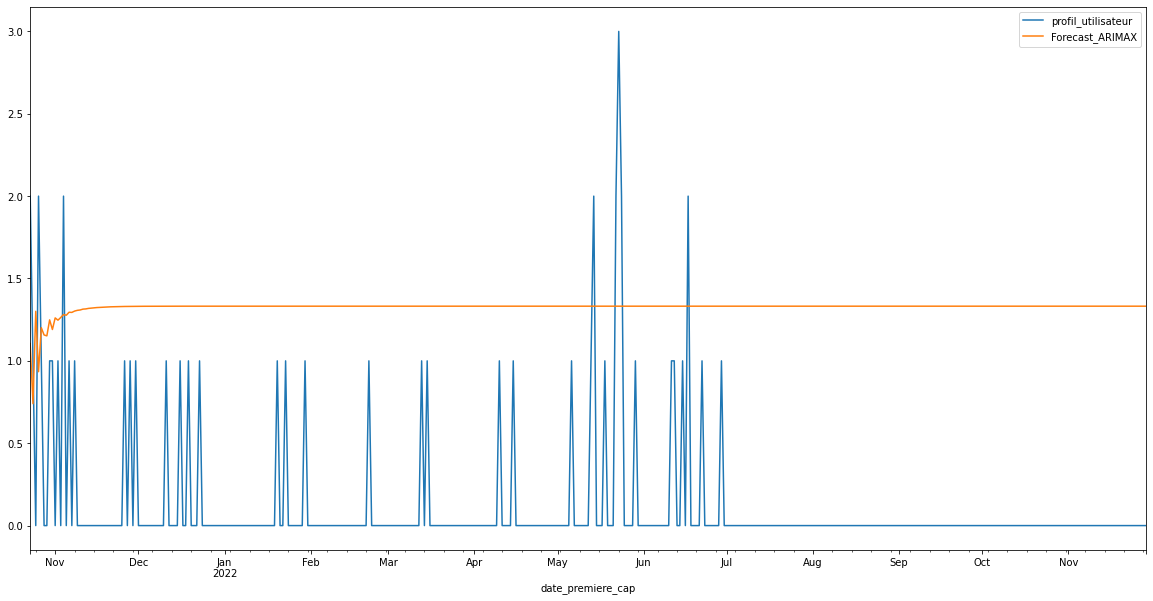

<AxesSubplot:xlabel='date_premiere_cap'>

In [0]:
test[["profil_utilisateur", "Forecast_ARIMAX"]].plot(figsize=(20, 10))

Out[63]:

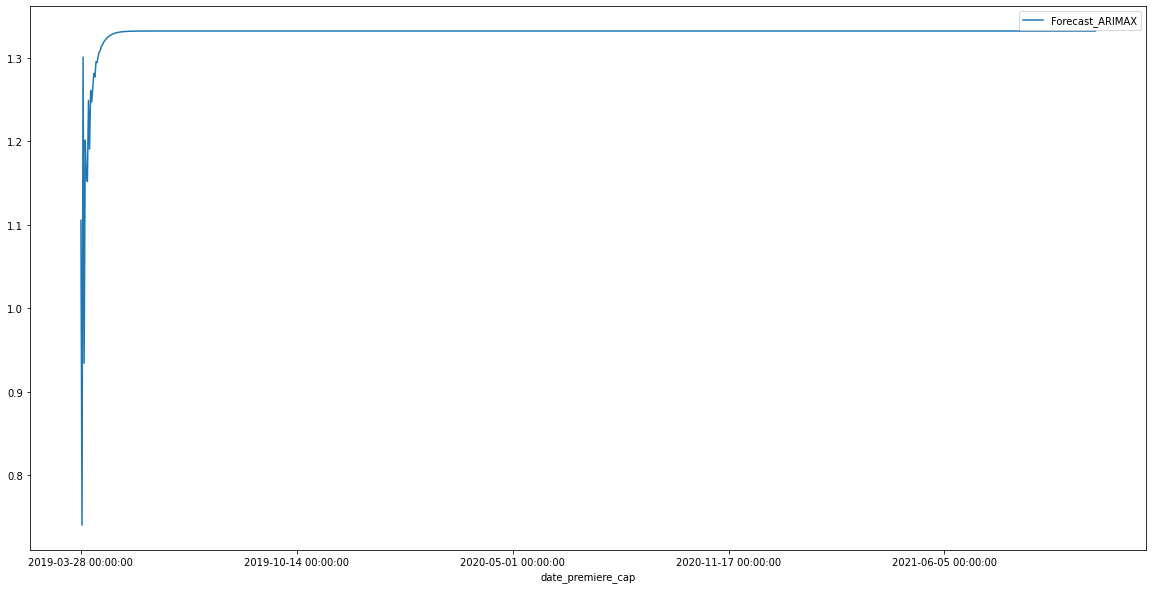

<AxesSubplot:xlabel='date_premiere_cap'>

In [0]:
train[["profil_utilisateur", "Forecast_ARIMAX"]].plot(figsize=(20, 10))


In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(test.profil_utilisateur,(test.Forecast_ARIMAX))))
 
print("\nMAE of Auto ARIMAX:", mean_absolute_error(test.profil_utilisateur, test.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 1.2737204377339828

MAE of Auto ARIMAX: 1.242557259018663